# Import Libraries

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import os, datetime, json
from os.path import join, basename, dirname
from glob import glob
from functools import reduce
from IPython.display import display
from PIL import Image

from imgaug import augmenters as iaa

In [2]:
# GPU 비활성화
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# GPU 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9827514639308586692
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5765005312
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9061944015430476451
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:0a:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


# Data Load

## 경로 설정

In [4]:
path_to_current = os.getcwd()
path_to_dataset = join(path_to_current, 'open')
print(f'{path_to_current = }')

path_to_current = 'e:\\VSCodeProjects\\DACON_Anomoly_Detection'


## train data -> DataFrame

In [5]:
df = pd.read_csv(join(path_to_dataset, 'train_df.csv'), index_col=['index'])

display(df)

file_name       class state            label
index                                              
0      10000.png  transistor  good  transistor-good
1      10001.png     capsule  good     capsule-good
2      10002.png  transistor  good  transistor-good
3      10003.png        wood  good        wood-good
4      10004.png      bottle  good      bottle-good
...          ...         ...   ...              ...
4272   14272.png  transistor  good  transistor-good
4273   14273.png  transistor  good  transistor-good
4274   14274.png        grid  good        grid-good
4275   14275.png      zipper  good      zipper-good
4276   14276.png       screw  good       screw-good

[4277 rows x 4 columns]

## 모델학습을 위해 데이터 전처리

In [6]:
# 절대 경로로 변환
df.file_name = df.file_name.apply(lambda path: join(path_to_dataset, 'train', path))

# class numbering
categories = {class_:i for i, class_ in enumerate(df['class'].unique())}
print(f"{categories = }")

# class: str -> int
df['class'] = df['class'].apply(lambda class_: categories[class_])

display(df)

categories = {'transistor': 0, 'capsule': 1, 'wood': 2, 'bottle': 3, 'screw': 4, 'cable': 5, 'carpet': 6, 'hazelnut': 7, 'pill': 8, 'metal_nut': 9, 'zipper': 10, 'leather': 11, 'toothbrush': 12, 'tile': 13, 'grid': 14}


file_name  class state  \
index                                                                   
0      e:\VSCodeProjects\DACON_Anomoly_Detection\open...      0  good   
1      e:\VSCodeProjects\DACON_Anomoly_Detection\open...      1  good   
2      e:\VSCodeProjects\DACON_Anomoly_Detection\open...      0  good   
3      e:\VSCodeProjects\DACON_Anomoly_Detection\open...      2  good   
4      e:\VSCodeProjects\DACON_Anomoly_Detection\open...      3  good   
...                                                  ...    ...   ...   
4272   e:\VSCodeProjects\DACON_Anomoly_Detection\open...      0  good   
4273   e:\VSCodeProjects\DACON_Anomoly_Detection\open...      0  good   
4274   e:\VSCodeProjects\DACON_Anomoly_Detection\open...     14  good   
4275   e:\VSCodeProjects\DACON_Anomoly_Detection\open...     10  good   
4276   e:\VSCodeProjects\DACON_Anomoly_Detection\open...      4  good   

                 label  
index                   
0      transistor-good  
1         capsule-good  
2      transistor-good  
3            wood-good  
4          bottle-good  
...                ...  
4272   transistor-good  
4273   transistor-good  
4274         grid-good  
4275       zipper-good  
4276        screw-good  

[4277 rows x 4 columns]

In [7]:
x_train_all, y_train_all = df.file_name.values, df['class'].values
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all,
                                                  test_size=.05, random_state=0)
print(f'{len(x_train) = }\n{len(x_val) = }')

len(x_train) = 4063
len(x_val) = 214


# Model Train

## 입력데이터 조정
* 과적합을 위해서 매번 입력이미지를 변형
* GPU 메모리 부족 방지를 위해 Generator 사용

In [31]:
input_shape = (224, 224)

# 과적합 방지를 위해서 매번 입력 이미지를 변형한다.
seq = iaa.Sequential([
    iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
               scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}),
    iaa.Rotate(rotate=(-180, 180)),
])

def normalize(x):
    return x / 255

# 과적합 방지를 위해서 매번 입력 이미지를 변형한다.
seq = iaa.Sequential([
    iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
               scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}),
    iaa.Rotate(rotate=(-35, 35)),
])

def steps(x, batch_size):
    return (len(x) // batch_size) + 1 if len(x) % batch_size else len(x) // batch_size

def images2arrs(x, input_shape):
    arrs = []
    for image in x:
        arr = np.array(Image.open(image).resize(input_shape), dtype=np.uint8)
        # Grayscale -> RGB
        if len(arr.shape) == 2:
            arr = np.tile(arr[:, :, np.newaxis], reps=[1, 1, 3])
            
        arrs.append(arr)
        
    return np.array(arrs, dtype=np.float32)

# 메모리 부족현상 방지를 위해서 제너레이터 사용한다.
def x_y_generator(x, y, batch_size=64, epochs=1, transform=False, input_shape=(224, 224), shuffle=True):
    seq = iaa.Sequential([
        iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)},
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}),
        iaa.Rotate(rotate=(-35, 35)),
    ])
        
    steps_ = steps(x, batch_size)
    batch_order = np.arange(steps_)
    while epochs:
        if shuffle:
            np.random.shuffle(batch_order)  # 배치들간의 순서 섞기
        for order in batch_order:
            start = order * batch_size
            end   = start + batch_size
            
            images = images2arrs(x[start:end], input_shape=input_shape)
            # images = np.array([
            #     np.array(Image.open(image).resize(input_shape), dtype=np.float32) for image in x[start:end]
            # ])

            yield (
                normalize(seq(images=images)) if transform else normalize(images),
                y[start:end],
            )
        epochs -= 1

## 모델 불러오기

In [9]:
classes = len(df['class'].unique())

model = tf.keras.applications.densenet.DenseNet121(
    include_top=False,          # include fully-connected layer
    weights='imagenet',         # 미리 학습된 데이터 사용
    input_tensor=None,
    input_shape=(*input_shape, 3),     # 224 x 224 이미지 사용
    pooling=None,
    classes=classes,            # 모든 품종의 클래스 사용
)

# 모델 커스터마이징
x = model.output
x = GlobalAveragePooling2D(name = "avg_pool")(x)
outputs = Dense(classes, activation=tf.nn.softmax, name="predictions")(x)

model = tf.keras.Model(model.input, outputs)

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,  metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

## Hyperparameter 설정

In [13]:
batch_size = 16
steps_per_epoch = steps(x_train, batch_size)
validation_steps = steps(x_val, batch_size)
epochs = 5

## Callback 설정

In [14]:
log_dir = join(path_to_current, 'logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

# 폴더 생성 함수
mkdirs = lambda dir: os.makedirs(dir) if not os.path.exists(dir) else None
mkdirs(log_dir)

print(log_dir)

checkpoint = ModelCheckpoint(join(log_dir, 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'),
                             monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=1,
                               restore_best_weights=True)

e:\VSCodeProjects\DACON_Anomoly_Detection\logs\20220409-171017


## 모델 학습

In [15]:
history_ = model.fit(x_y_generator(x_train, y_train, batch_size=batch_size, epochs=epochs, transform=True),
                     epochs=epochs, steps_per_epoch=steps_per_epoch,
                     validation_data=x_y_generator(x_val, y_val, batch_size=batch_size, epochs=-1, transform=True),
                     validation_batch_size=batch_size, validation_steps=validation_steps,
                     callbacks=[checkpoint, early_stopping])

Epoch 1/5
254/254 [==============================] - 130s 473ms/step - loss: 0.0794 - accuracy: 0.9877 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 2/5
254/254 [==============================] - 117s 462ms/step - loss: 0.0057 - accuracy: 1.0000 - val_loss: 3.5685e-04 - val_accuracy: 1.0000
Epoch 3/5
254/254 [==============================] - 117s 460ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 2.1049e-04 - val_accuracy: 1.0000
Epoch 4/5
254/254 [==============================] - 121s 479ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.5482e-04 - val_accuracy: 1.0000
Epoch 5/5
254/254 [==============================] - 121s 478ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.3535e-04 - val_accuracy: 1.0000


In [16]:
print(json.dumps(history_.history, ensure_ascii=False, indent='\t'))

{
	"loss": [
		0.07941661775112152,
		0.005736219696700573,
		0.0032106877770274878,
		0.002542575355619192,
		0.0018506810301914811
	],
	"accuracy": [
		0.9876938462257385,
		1.0,
		1.0,
		1.0,
		1.0
	],
	"val_loss": [
		0.0017756299348548055,
		0.00035685140755958855,
		0.0002104861632687971,
		0.00015481877198908478,
		0.0001353467087028548
	],
	"val_accuracy": [
		1.0,
		1.0,
		1.0,
		1.0,
		1.0
	]
}


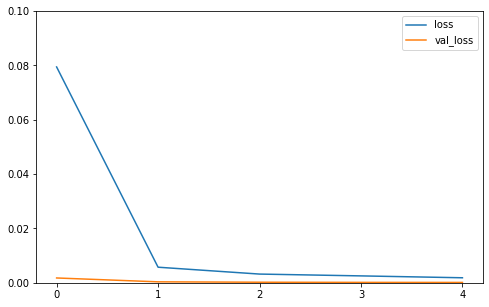

In [17]:
loss = history_.history['loss']
val_loss = history_.history['val_loss']
plt.figure(figsize=(8,5))
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.ylim(0, .1)

plt.xticks(ticks=range(len(loss)))
plt.legend()
plt.show()

# test data 예측

## 모델 불러오기

In [31]:
# log_dir = join(path_to_current, 'logs', '20220409-133827')
# h5 = join(log_dir, 'ep005-loss0.002-val_loss0.000.h5')

# model.load_weights(h5)

## 예측 함수

In [51]:
# 500개 불러오기
x_test = np.array(glob(join(path_to_dataset, 'test', '*.png')))

def predict(x):
    steps_per_epoch = steps(x, batch_size)
    for i, (x, _) in enumerate(x_y_generator(x, np.array([0]*len(x)),
                                             batch_size=batch_size, epochs=1, shuffle=False)):
        print(f'\r{i+1} / {steps_per_epoch}', end='')
        yield model.predict(x)

r = reduce(
    lambda x, y: x + y.tolist(),    # 규칙(함수)
    predict(x_test),                # iterable
    [],                             # 초기값
)

pred = np.argmax(np.array(r), axis=-1)

pred[:100]

135 / 135

array([13, 14,  0, 13, 13,  8,  1,  7, 11, 11,  3,  2, 10,  4, 13,  3, 14,
        6,  6,  8, 13, 10,  3,  4,  8,  4,  8,  4, 11,  2,  4,  5,  4, 10,
       10, 10, 11,  5, 11,  9,  9,  5,  4,  1,  9, 13, 12,  1, 10,  4,  5,
        0,  7,  7, 10,  9,  6,  6, 11,  1,  0,  8,  1, 10,  1, 11,  0,  1,
        8,  9, 14,  2,  7, 13, 11, 10,  5, 11,  5,  5,  8,  2,  4,  2,  0,
        3, 10,  6, 11, 10, 11, 10,  5,  9,  4, 13,  0,  0,  9,  9],
      dtype=int64)

## 예측 이미지 시각화

rows X columns: 10 X 10


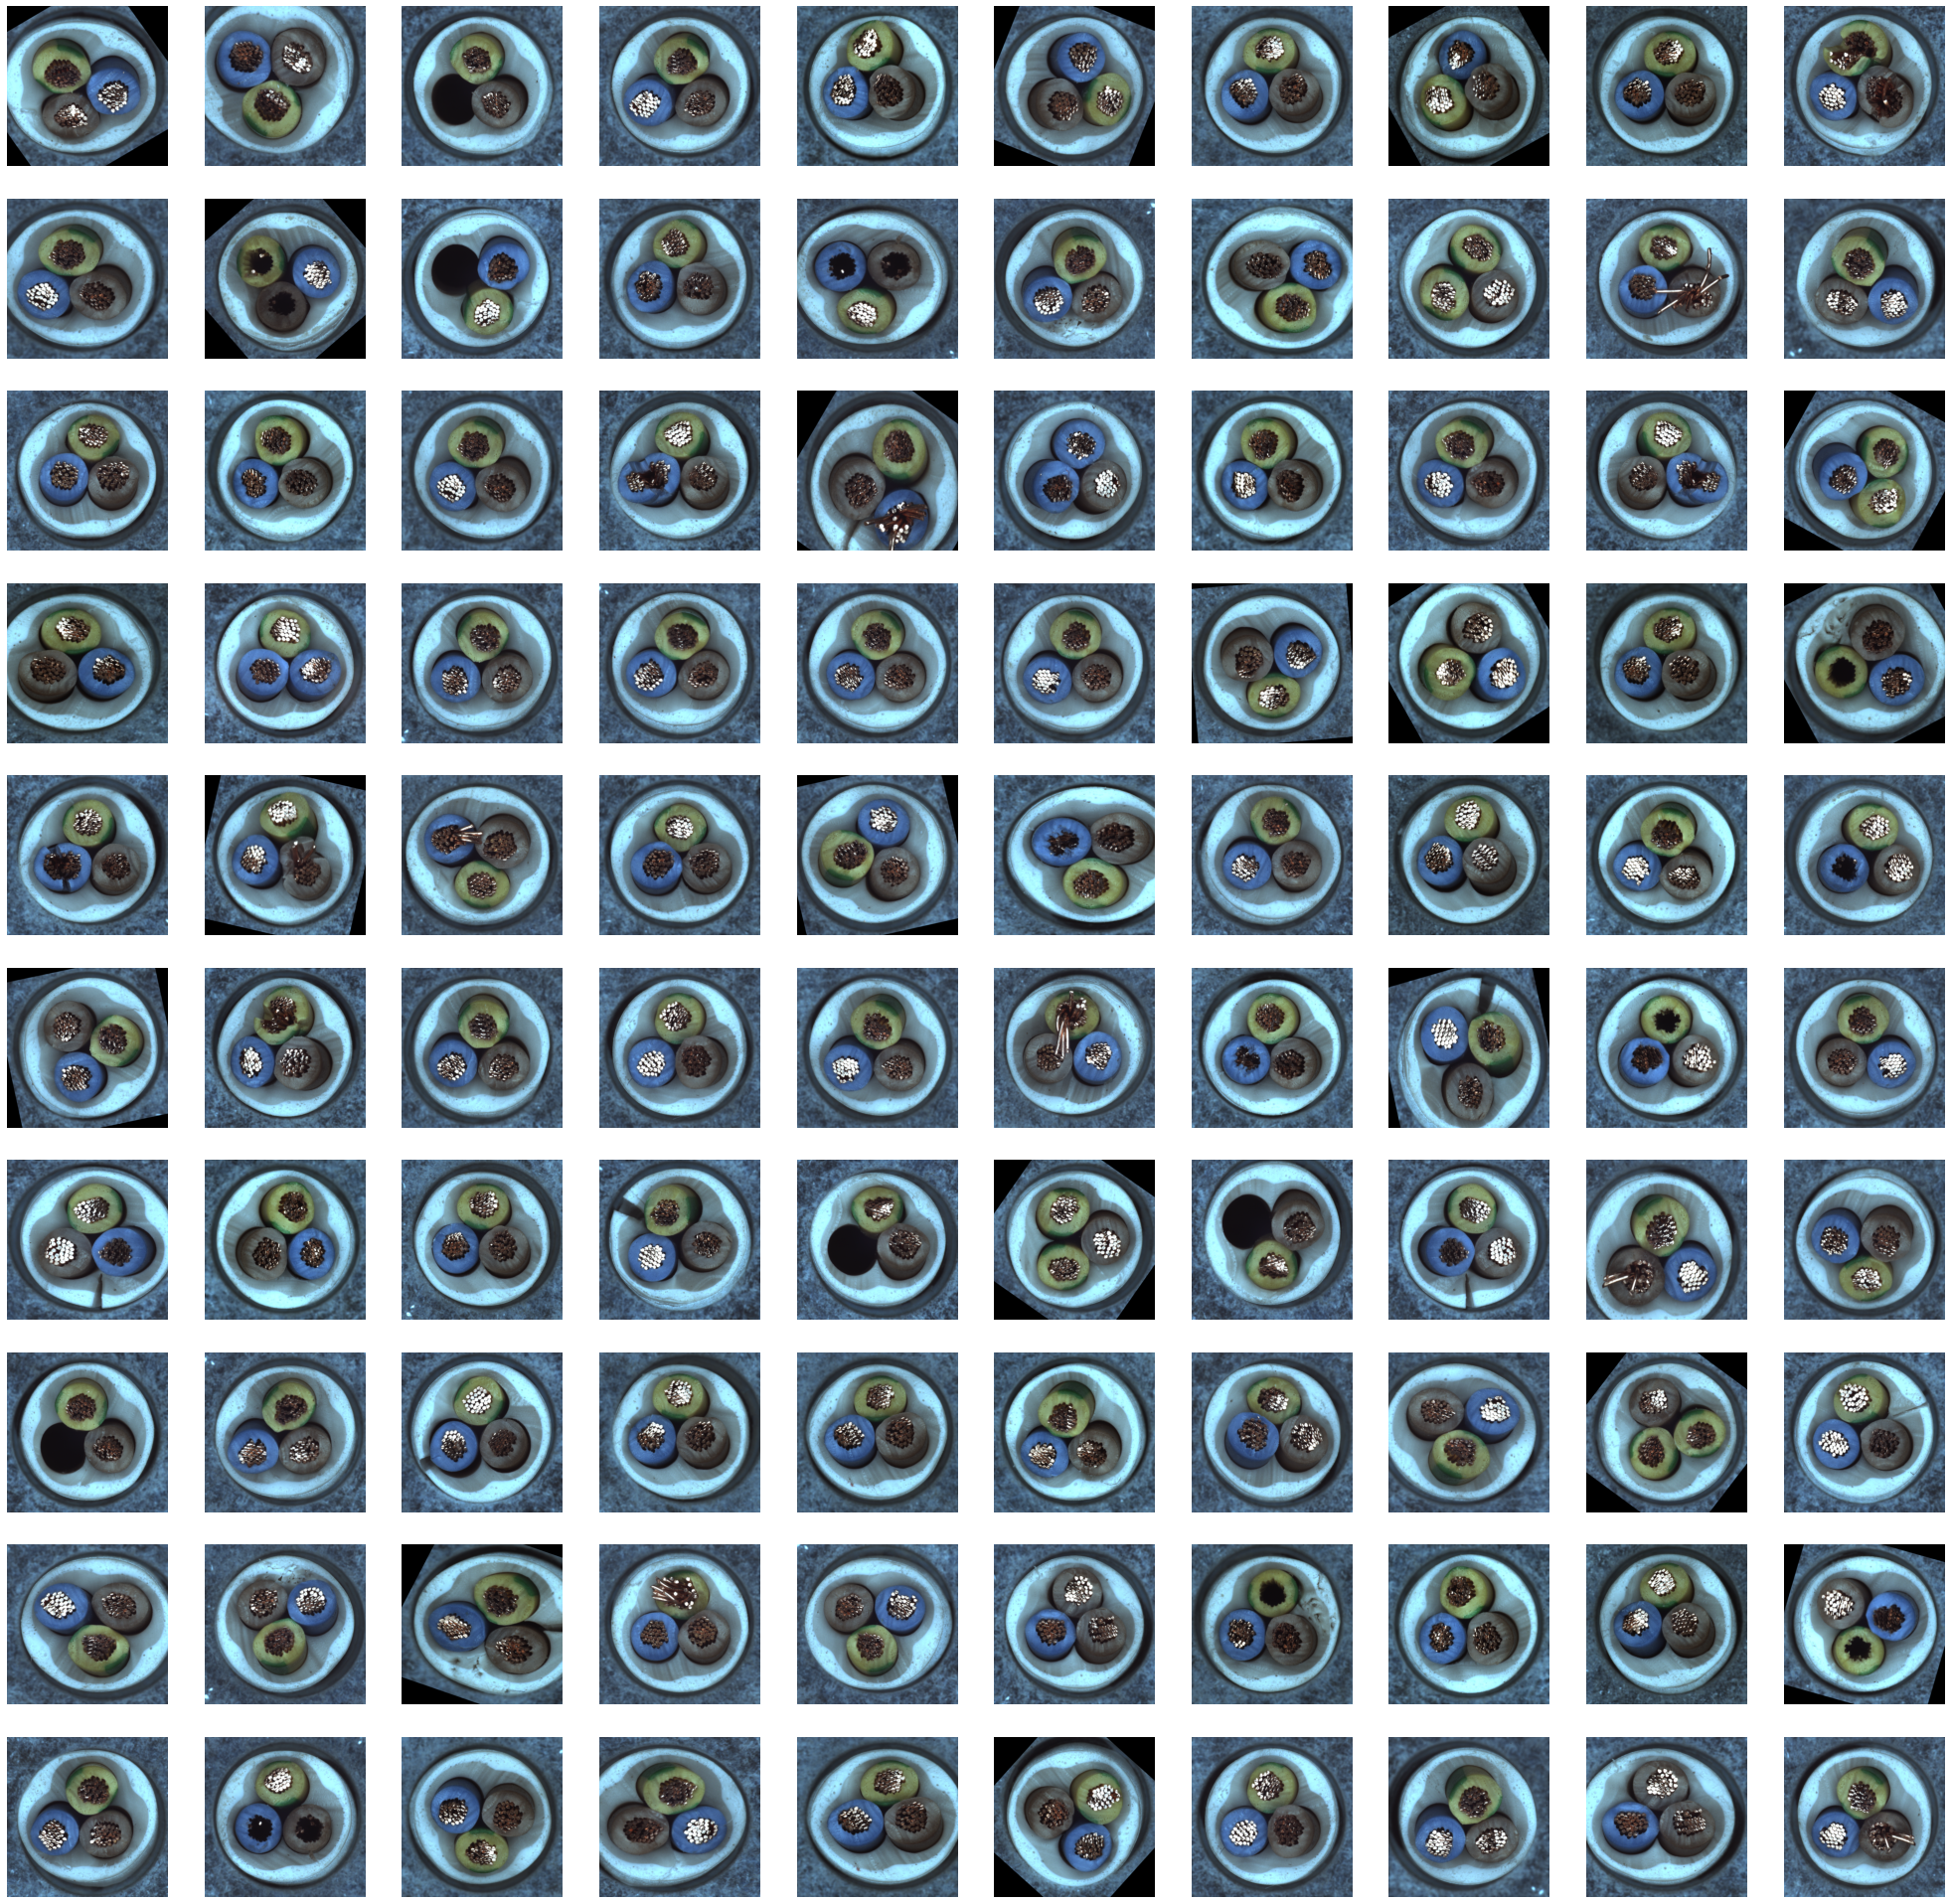

In [52]:
rows = 10
columns = 10
print(f'rows X columns: {rows} X {columns}')

fig, axes = plt.subplots(rows, columns, facecolor='white', figsize=(columns * 3.5, rows * 3.5))

[ax.axis('off') for ax in axes.ravel()] # 축 제거

# cable만 출력
mask = pred == categories['cable']
for ax, filename, pre in zip(axes.ravel(), x_test[mask], pred[mask]):
    # 이미지 입력
    img = cv2.imread(join(path_to_dataset, 'test', filename))
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

## 예측 데이터 csv로 저장

In [60]:
df_1st_classification = pd.DataFrame(
    data={
        'file_name': x_test,
        'class': pred,
    },
)

categories_reverse = {
    val: key for key, val in categories.items()
}

# train_df.csv와 같게 데이터 후처리
df_1st_classification['file_name'] = df_1st_classification['file_name'].apply(lambda fullpath: basename(fullpath))
df_1st_classification['class'] = df_1st_classification['class'].apply(lambda y: categories_reverse[y])

# csv 저장
df_1st_classification.to_csv(join(log_dir, '1st_classification.csv'))
df_1st_classification.to_csv(join(path_to_current, '1st_classification.csv'))

display(df_1st_classification)

file_name       class
0     20000.png        tile
1     20001.png        grid
2     20002.png  transistor
3     20003.png        tile
4     20004.png        tile
...         ...         ...
2149  22149.png        tile
2150  22150.png       screw
2151  22151.png        grid
2152  22152.png       cable
2153  22153.png      zipper

[2154 rows x 2 columns]